In [20]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

## Text preprocessing

In [21]:
import tensorflow as tf
import numpy as np

In [22]:
word_dict = np.load('./dataset/enVocab.npy').tolist()
idx_dict = np.load('./dataset/enRev.npy').tolist()

首先，先把英文的 dictionary load 進來，就能將單字轉成 ID；同時也把 decoder load 進來，就能將 ID 轉回單字。  
原本想嘗試自己建構 dictionary，不過有同學說 memory 會不夠，因此我也就沒有多做嘗試。

In [23]:
punctuations = ['.', ',', '!', '?', '-', '_', '\"']
data = []

with open('./dataset/conversations.txt', 'r', encoding='utf-8') as text:
    lines = text.readlines()
    
    for lines in lines:
        lines = lines.strip()
        for punc in punctuations:
            if punc in lines:
                lines = lines.replace(punc, '')
        words = lines.split()
        words = [w for w in words if w]
        
        if words:
            data.append(words)
    text.close()
    del lines
    

In [24]:
print(data[0])

['can', 'we', 'make', 'this', 'quick', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', 'again']


接著要對 conversations 做 preprocessing。  
1. 我先去掉讀進來的句子頭尾的空白。  
2. 先把句子中的標點符號去掉。
3. 把句子切成一個個單字的 list，再把裡面的空的單字去掉。
4. 最後，如果是有單字的句子我才把他加進最後的 data 中，避免有空的句子。

接著，將 data 中的 conversations 分成提問和回答。  
我的作法是，把單數的句子當作提問，雙數的句子當作回應。

In [25]:
question = []
ans = []
for idx, line in enumerate(data):
    tmp = []
    tmp.append(word_dict['<BEG>'])# add <BEG>
    for word in line:
        if word in word_dict:
            tmp.append(word_dict[word])
    
    if idx%2 == 0:# for question
        tmp.append(word_dict['<END>'])# add <END>
        question.append(tmp)
    elif idx%2 == 1:# for ans
        tmp.append(word_dict['<END>'])# add <END>
        ans.append(tmp)

再來，要考慮到 max length。  
根據我的實驗，太長會讓我的 RNN 失敗，所以我想要限制住每一句的 max length，如果大於 max_length 我就只取到 max_length。

In [26]:
question_max_length = sorted([len(question[i]) for i in range(len(question))], reverse=True)[0]
ans_max_length = sorted([len(ans[i]) for i in range(len(ans))], reverse=True)[0]
print('Questions max length:', question_max_length)
print('Ans max length:', ans_max_length)

Questions max length: 468
Ans max length: 309


In [27]:
max_length = 60 # hyperparameter

question_short = []
ans_short = []

for i in range(len(ans)):
    if len(question[i]) > max_length:
        question_short.append(question[i][:max_length])
    else:
        question_short.append(question[i])
        
    if len(ans[i]) > max_length:
        ans_short.append(ans[i][:max_length])
    else:
        ans_short.append(ans[i])

In [28]:
new_question_max_length = sorted([len(question_short[i]) for i in range(len(question_short))], reverse=True)[0]
new_ans_max_length = sorted([len(ans_short[i]) for i in range(len(ans_short))], reverse=True)[0]
print('Questions max length:', new_question_max_length)
print('Ans max length:', new_ans_max_length)

Questions max length: 60
Ans max length: 60


## Batch preparation

In [29]:
BATCH_SIZE = 128

batch size 的部分，如果我用 256 的話會完全跑不起來，所以我最後只使用128。

In [30]:
class BatchGenerator(object):
    def __init__(self, en_corpus, ch_corpus, en_pad, ch_pad, en_max_len, ch_max_len, batch_size):
        #self.n = len(en_corpus)
        self.batch_num = len(en_corpus) // batch_size
        self.n = self.batch_num * batch_size

        self.en_corpus = en_corpus
        self.ch_corpus = ch_corpus

        self.en_pad = en_pad
        self.ch_pad = ch_pad

        self.en_max_len = en_max_len
        self.ch_max_len = ch_max_len
        self.batch_size = batch_size
        
        self.xs = [np.zeros(self.n, dtype=np.int32) for _ in range(en_max_len)]  # encoder inputs
        self.ys = [np.zeros(self.n, dtype=np.int32) for _ in range(ch_max_len)]  # decoder inputs
        self.gs = [np.zeros(self.n, dtype=np.int32) for _ in range(ch_max_len)]  # decoder outputs
        self.ws = [np.zeros(self.n, dtype=np.float32) for _ in range(ch_max_len)]  # decoder weight for loss caculation
        for b in range(self.batch_num):
            for i in range(b * batch_size, (b + 1) * batch_size):
                for j in range(len(en_corpus[i]) - 2):
                    self.xs[j][i] = en_corpus[i][j + 1]
                for j in range(j + 1, en_max_len):
                    self.xs[j][i] = en_pad

                for j in range(len(ch_corpus[i]) - 1):
                    self.ys[j][i] = ch_corpus[i][j]
                    self.gs[j][i] = ch_corpus[i][j + 1]
                    self.ws[j][i] = 1.0
                for j in range(j + 1, ch_max_len):  # don't forget padding and let loss weight zero
                    self.ys[j][i] = ch_pad
                    self.gs[j][i] = ch_pad
                    self.ws[j][i] = 0.0      
    def get(self, batch_id):
        x = [ self.xs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size] for i in range(self.en_max_len) ]
        y = [ self.ys[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size] for i in range(self.ch_max_len) ]
        g = [ self.gs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size] for i in range(self.ch_max_len) ]
        w = [ self.ws[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size] for i in range(self.ch_max_len) ]
        return x, y, g, w

製作 batch 的方法基本上差不多。  
比較值得提到的是我在這邊沒有碰到記憶體不足的問題，可以直接在 initial 時把所有的結果都做好，並在 call get 時把需要的 batch 直接擷取出來就好。

In [31]:
batch = BatchGenerator(question_short, ans_short, word_dict['<PAD>'], word_dict['<PAD>'], max_length, max_length, BATCH_SIZE)
x, y, g, w = batch.get(2)
for i in range(2):
    print(' '.join([idx_dict[x[j][i]] for j in range(max_length)]))
    print(' '.join([idx_dict[y[j][i]] for j in range(max_length)]))
    print(' '.join([idx_dict[g[j][i]] for j in range(max_length)]))
    print('')

the <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

##  Model training

In [32]:
EPOCHS = 40

In [33]:
class ChatBox:

    def __init__(self, en_max_len, ch_max_len, en_size, ch_size):
        self.en_max_len = en_max_len
        self.ch_max_len = ch_max_len

        with tf.variable_scope('seq2seq_input/output'):
            self.enc_inputs = [ tf.placeholder(tf.int32, [None]) for i in range(en_max_len) ]  # time mojor feed
            self.dec_inputs = [ tf.placeholder(tf.int32, [None]) for i in range(ch_max_len) ]
            self.groundtruths = [ tf.placeholder(tf.int32, [None]) for i in range(ch_max_len) ]
            self.weights = [ tf.placeholder(tf.float32, [None]) for i in range(ch_max_len) ]

        with tf.variable_scope('seq2seq_rnn'):  # training by teacher forcing
            self.out_cell = tf.contrib.rnn.LSTMCell(512)
            self.outputs, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                  self.enc_inputs, self.dec_inputs, self.out_cell, en_size, ch_size, 300)
        with tf.variable_scope('seq2seq_rnn', reuse=True):  # predict by feeding previous
            self.pred_cell = tf.contrib.rnn.LSTMCell(512, reuse=True)  # reuse cell for train and test
            self.predictions, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                  self.enc_inputs,
                  self.dec_inputs,
                  self.pred_cell,
                  en_size,
                  ch_size,
                  300,
                  feed_previous=True)
        with tf.variable_scope('loss'):
          # caculate weighted loss
            self.loss = tf.reduce_mean(tf.contrib.legacy_seq2seq.sequence_loss_by_example(
                  self.outputs, self.groundtruths, self.weights))
            self.optimizer = tf.train.AdamOptimizer(0.002).minimize(self.loss)

        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        self.sess.run(tf.global_variables_initializer())

    def train(self, x, y, g, w):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]  # show how to feed a list

        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]
            fd[self.groundtruths[i]] = g[i]
            fd[self.weights[i]] = w[i]

        loss, _ = self.sess.run([self.loss, self.optimizer], fd)

        return loss

    def output(self, x, y):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]

        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]

        out = self.sess.run(self.outputs, fd)
        return out

    def predict(self, x, ch_beg):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]

        for i in range(self.ch_max_len):  # when feed previous, the fist token should be '<BEG>', and others are useless
            if i == 0:
                fd[self.dec_inputs[i]] = np.ones(x[i].shape, dtype=np.int32) * ch_beg
            else:
                fd[self.dec_inputs[i]] = np.zeros(x[i].shape, dtype=np.int32)

        pd = self.sess.run(self.predictions, fd)

        return pd

    def save(self, e):
        self.saver.save(self.sess, './model/chatbox/chatbox%d.ckpt' % (e + 1))

    def restore(self, e):
        self.saver.restore(self.sess, './model/chatbox/chatbox%d.ckpt' % (e))

In [34]:
tf.reset_default_graph()
model = ChatBox(max_length, max_length, len(word_dict), len(word_dict))

In [35]:
batch = BatchGenerator(question_short, ans_short, word_dict['<PAD>'], word_dict['<PAD>'], max_length, max_length, BATCH_SIZE)

In [36]:
%%time
rec_loss = []
batch_num = len(ans_short)//BATCH_SIZE

with tf.device('/gpu:0'):
    for e in range(EPOCHS):
        train_loss = 0
        print('#Epoch: ', e+1)
        for b in range(batch_num):
            x, y, g, w = batch.get(b)
            batch_loss = model.train(x, y, g, w)
            train_loss += batch_loss

        train_loss /= batch_num
        rec_loss.append(train_loss)
        model.save(e)

#Epoch:  1
#Epoch:  2
#Epoch:  3
#Epoch:  4
#Epoch:  5
#Epoch:  6
#Epoch:  7
#Epoch:  8
#Epoch:  9
#Epoch:  10
#Epoch:  11
#Epoch:  12
#Epoch:  13
#Epoch:  14
#Epoch:  15
#Epoch:  16
#Epoch:  17
#Epoch:  18
#Epoch:  19
#Epoch:  20
#Epoch:  21
#Epoch:  22
#Epoch:  23
#Epoch:  24
#Epoch:  25
#Epoch:  26
#Epoch:  27
#Epoch:  28
#Epoch:  29
#Epoch:  30
#Epoch:  31
#Epoch:  32
#Epoch:  33
#Epoch:  34
#Epoch:  35
#Epoch:  36
#Epoch:  37
#Epoch:  38
#Epoch:  39
#Epoch:  40
Wall time: 18h 21min 6s


In [37]:
np.save('./model/chatbox/rec_loss.npy', rec_loss)

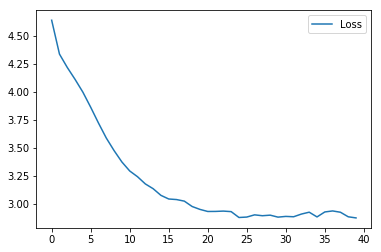

In [40]:
rec_loss = np.load('./model/chatbox/rec_loss.npy')

import matplotlib.pyplot as plt

plt_loss = plt.plot([rec_loss[i] for i in range(len(rec_loss))])
plt.legend(['Loss'])
plt.show()

經過 40 個 epochs，從 learning curve 可以發現 loss 有 converge。

## Cherry pick

In [38]:
import nltk


def cherry_pick(records, n, upper_bound=1.0):
    bleus = []

    for en, ch_gr, ch_pd in records:
        bleu = nltk.translate.bleu_score.sentence_bleu(
            [ch_gr], ch_pd)  # caculate BLEU by nltk
        bleus.append(bleu)

    lst = [i for i in range(len(records)) if bleus[i] <= upper_bound]
    lst = sorted(lst, key=lambda i: bleus[i], reverse=True)  # sort by BLEU score

    return [records[lst[i]] for i in range(n)]

In [46]:
import random as rd

records = []

for i in range(10):
    i = rd.randint(0, batch_num - 1)  # random pick one to translate

    x, y, g, w = batch.get(i)
    out = model.output(x, y)
    pd = model.predict(x, word_dict['<BEG>'])
    
    for j in range(10):
        j = rd.randint(0, BATCH_SIZE - 1)

        en = [idx_dict[x[i][j]] for i in range(max_length)]
        en = en[:en.index('<PAD>')]
        ch_gr = [idx_dict[g[i][j]] for i in range(max_length)]
        if '<END>' in ch_gr:
            ch_gr = ch_gr[:ch_gr.index('<END>')]
        ch_pd = [idx_dict[np.argmax(pd[i][j, :])] for i in range(max_length)]
        if '<END>' in ch_pd:
            ch_pd = ch_pd[:ch_pd.index('<END>')]

        records.append([en, ch_gr, ch_pd])

n = 12  # how many result we show
rec_cherry = cherry_pick(records, n)

for i in range(n):
    for j in range(3):
        print(' '.join(rec_cherry[i][j]))

    print('')

what think of the
nice voice
nice voice

and you must be look the since wild bill they say what do you think should i hate him
age
age

enough never
wrong
wrong

i wonder how that
turn it down
turn it down

what did you do to those people
nothing
nothing

to experience beyond anything ever known at least what i was promised when i bought it pleasure from heaven or hell i much care which
hell
hell

heard you had quite a night
yeah
yeah

no i have only activated your cognitive and communication
why
why

it appears to from us
from enterprise
from enterprise

what about
forget him
forget about the

listen not like he makes you feel like you belong and good it really is i wish i could do something about this but i i can promise you only two things always look this good i give up on you ever
i like that
i guess i can

i guess i kind of lost sight of things may the wind always be at your back and the sun always upon your face and the of carry you to dance with the stars love george
that was a

C:\Users\Rohan\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Rohan\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Rohan\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
